Programming Language: Python 3.6.9 in Google Colaboratory

Python Libraries used:
- google.colab (1.0.0)
- fastai (2.0.18)
- numpy (1.18.5)
- random (included in python distribution)
- os (included in python distribution)
- pandas (1.1.4)
- nltk (3.2.5)
- re (included in python distribution)
- string (included in python distribution)
- tqdm (included in python distribution)
- torch (1.6.0+cu101)
- torchvision (0.7.0+cu101)

**Section 1.**

Setting directory locations

In [ ]:
#Set Working Directory

###SET WORKING DIRECTORY DETAILS BELOW. CONSULT README FOR MORE INFORMATION
# Set drive location to the location of this file. e.g drive_location = 'my drive/submission'
drive_selection = 'My Drive/'#'Shared drives/'FIT5149 Assignment 2/'#By default, the code links to your personal drive, adjust this variable to link to shared drives instead.
drive_location = 'fastai-scientific'#By default, the distribution is assumed to be located on at the top level of your Google Drive folder structure. Adjust this varibale to point to another lcoation.
###

mount_location = '/content/drive/'
home_directory = mount_location + drive_selection + drive_location

data_directory = '/data'
language_directory = '/language models'
model_directory = '/models'
output_directory = '/model output'

#Declare the source data
train_file = '/train_data_labels.csv'
test_file = '/test_data.csv'

**Section 2**

Mount Google Drive File System, install required package versions and import required packages.

In [ ]:
#Import the google.colab package to mount the google drive.
from google.colab import drive

#Mount google drive to make the share drive content available.
drive.mount(mount_location)

Mounted at /content/drive/


In [ ]:
#Import required packages
import numpy as np
import random
import os
import pandas as pd
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from tqdm import notebook

In [ ]:
import nltk
nltk.download('stopwords')# Download the english stopwords for use in the data cleaning
nltk.download('averaged_perceptron_tagger')# Download the perceptron tag data for use in pre-processing step prior to lemmatization
nltk.download('wordnet')# Download the wordnet data for lemmatization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#Install torch and torchvision to the below specified versions.
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 26kB/s 
     |████████████████████████████████| 5.9MB 4.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
#Install fatai and fastcore to the below specified versions.
!pip install fastai==2.0.16 fastcore==1.2.5

#Import required packages
from fastai.text.all import *

     |████████████████████████████████| 194kB 7.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


**Section 3**

Define and call a seeding funciton that will ensure reproducability.

In [ ]:
#Configure seed settings for all variables to ensure reproducability
def reset_seed():
  seed = 123456789

  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  #Adjust the torch backend parameters to avoid the use of non-deterministic algorithms for reproducability.
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  print('Seed reset to value ', seed)

#Set the seed value.
reset_seed()

Seed reset to value  123456789


**Section 4**

Commence Text pre-processing and cleaning.

In [ ]:
stopwords = set(stopwords.words('english'))#Load stopwords into a set to improve speed on repeated calls.

In [ ]:
#Define a class that will manage the cleaning process.
#The text_processor class will take test or train data as an input,
#Perfrom all neccesary cleaning steps,
#Perform lemmatization
#And return processed data to calling functions.

class text_processor():
    def __init__(self):
        #Decalre global variables for formating and function use.
        self.line_break = '\n---------------'
        print(self.line_break)
        print('Creating data dictionaries.')
        self.label_dict = {} #label_dict will hold the class labels for the training data
        self.abstract_dict = {} #abstract_dict will hold the input abstracts
        self.corpus_list = [] #corpus_list will maintain a list of all words in the corpus for statistical purposes
        print('Dictionaries created.')
        
        
    def data_setup(self, input_df, data_type = 'train'):
        #Data setup takes a dataframe input contain one column of ids and one column of abstracts.
        #If the data type is train, then an additional column of labels will exist.
        
        #Extract the dataframe into lists for easier loading into dictionaries.
        print(self.line_break)
        print('Extracting ids and abstract from data frame.')
        try:
            abstract_id = input_df.train_id.to_list()
        except:
            abstract_id = input_df.test_id.to_list()
            
        abstract = input_df.abstract.to_list()
        print('Labels and Abstract loaded into lists')
        
        #If the data type is train, then also load the labels.
        if data_type == 'train':
            print(self.line_break)
            print('Extracting Labels from train data.')
            label = input_df.label.to_list()
            print('Labels extracted.')
        
        print(self.line_break)
        self.total_documents = len(abstract_id)
        print('The total number of documents in the corpus is ',self.total_documents,'.')

        print(self.line_break)
        print('Loading the data into dictionaries')
        #Load the data into dictionaries for processing
        for n in range(0, len(abstract_id)):
            if data_type == 'train':
                self.label_dict[abstract_id[n]] = label[n]

            self.abstract_dict[abstract_id[n]] = abstract[n]
        print('Data loaded.')
        
        self.data_type = data_type
        
    def clean_data(self):
            
        def get_wordnet_pos(word):
          #This function takes the input word and returns a pos_tag based on the wordnet package.
            tag = nltk.pos_tag([word])[0][1][0].upper()
            res_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}

            return res_dict.get(tag, wordnet.NOUN)
                
        
        def clean_line(input_string):
            #A funtion that will clean a single input string of text.
            
            #Remove everything that isn't a character or space, repalce with whitespace to split out equations.
            input_string = re.sub(r'[^\w\s]',' ', input_string)

            #Convert all the characters to lower case.
            input_string = input_string.lower().split()
            
            #Strip punctuation.
            table = str.maketrans('', '', string.punctuation)#Create a mapping table that maps puncuation to an empty string.
            input_string = [word.translate(table) for word in input_string]#Apply the mapping to each word to remove punctuation.
            
            #Remove any digits
            input_string = [re.sub("[0-9]", "", word) for word in input_string]
            
            #Remove stop words.
            input_string = [word for word in input_string if word not in stopwords]
            input_string = [word for word in input_string if word != '']# Remove any leftover blank entries.
            
            #Lemmatize all the words to get each words root lemma.
            lemmatizer = WordNetLemmatizer()
            input_string = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in input_string]
            
            #Remove words less that 3 characters.
            input_string = [word for word in input_string if len(word) > 2]
            
            #Return the cleaned string to the calling function.
            return input_string
        
        
        #Create a list to hold all words from the text.
        self.corpus_list = []
        
        print(self.line_break)
        print('Cleaning Abstract Data.')
        #Set up a progress bar as pbar equal to the length of the absract dict.
        with notebook.tqdm(total=len(self.abstract_dict)) as pbar:

            #iterate through each abstract
            for key in self.abstract_dict:
                #Send each abstract to the cleaning function and use the returned clean text in its place.
                self.abstract_dict[key] = clean_line(self.abstract_dict[key])
                
                #Add the unique list of the words generated in the abstract to the corpus_list.
                self.corpus_list += list(set(self.abstract_dict[key]))
                
                #Update the progress bar by 1.
                pbar.update(1)
                
        print('Cleaning Complete.')

    def get_result(self):
        #This function consolidates the cleaned data and returns it to the calling function as a list, where each element is a label, abstract pair for train data
        #And an absract only for test data.
        output_list = []
        
        for key in self.abstract_dict:
            
            if self.data_type == 'train':
                #Insert the label to the front of the list
                self.abstract_dict[key].insert(0, self.label_dict[key])
            
            #Insert the id to the front of the list
            self.abstract_dict[key].insert(0, str(key))
            self.abstract_dict[key].append('\n')
            
            output_list.append(','.join(self.abstract_dict[key]))

        return output_list

In [ ]:
#Instantiate the text_processor class.
train_corpus = text_processor()
#Load in the raw training data for the text processor using pandas.
train_df = pd.read_csv(home_directory+train_file)
#Pass the test data to the text_processor funciton, note that the function assumes data is training data by default.
train_corpus.data_setup(train_df)
#Clean the input data.
train_corpus.clean_data()
#Return the cleaned test data to a list.
cleaned_data_train = train_corpus.get_result()


---------------
Creating data dictionaries.
Dictionaries created.

---------------
Extracting ids and abstract from data frame.
Labels and Abstract loaded into lists

---------------
Extracting Labels from train data.
Labels extracted.

---------------
The total number of documents in the corpus is  29638 .

---------------
Loading the data into dictionaries
Data loaded.

---------------
Cleaning Abstract Data.



Cleaning Complete.


In [ ]:
#Instantiate the text_processor class.
test_corpus = text_processor()
#Load in the raw training data for the text processor using pandas.
test_df = pd.read_csv(home_directory + test_file)
#Pass the test data to the text_processor funciton, ensuring it is identified as test data.
test_corpus.data_setup(test_df, 'test')
#Clean the input data.
test_corpus.clean_data()
#Return the cleaned test data to a list.
cleaned_data_test = test_corpus.get_result()


---------------
Creating data dictionaries.
Dictionaries created.

---------------
Extracting ids and abstract from data frame.
Labels and Abstract loaded into lists

---------------
The total number of documents in the corpus is  7410 .

---------------
Loading the data into dictionaries
Data loaded.

---------------
Cleaning Abstract Data.



Cleaning Complete.


In [ ]:
#Process the cleaned data into the neccessary format for transition into the fastai package.

clean_train = []

#Split each clean record into individual tokens.
for line in cleaned_data_train:
    clean_train.append(line.strip().split(','))

#Remove the train_id value (this will be the same as the index when we move into a dataframe.)
for n in range(0,len(clean_train)):
    clean_train[n] = clean_train[n][1:]

In [ ]:
train_df = pd.DataFrame(clean_train)# Load the abstract and label into a dataframe
#Create a new column which takes the abstract words only and omits the label into a new column.
train_df['Words'] = train_df[train_df.columns[1:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)
#Remove the previously loaded words which were represented as columns.
train_df.drop(train_df.iloc[:,1:281], inplace=True, axis=1)

#Rename the labels column to an appropriate title.
train_df=train_df.rename(columns = {0:'Label'})

In [ ]:
#Return the first 5 rows of the training data for visual inspection.
train_df.head()

,Label,Words
0,cs,save special case current training method generative adversarial network gans best guaranteed converge local nash equilibrium lne lnes however arbitrarily far actual nash equilibrium implies guarantee quality found generator classifier paper proposes model gans explicitly finite game mixed strategy thereby ensure every lne formulation propose solution method proven monotonically converge resource bound nash equilibrium increase computational resource find well solution empirically demonstrate method less prone typical gan problem mode collapse produce solution less exploitable produce gans...
1,math.DS,consider dynamical system finitely many equilibrium perturbed small noise addition control expensive control control process optimal ergodic criterion run cost consists sum control effort penalty function state space study optimal stationary distribution control process variance noise becomes vanishingly small show depend relative magnitude noise variance run cost control one identify three regime optimal control force invariant distribution process concentrate near equilibrium characterize accord regime also obtain moment bound optimal stationary distribution moreover show vicinity point ...
2,cs,consider discrete dynamical system ant like agent engage sequence pursuit graph environment agent emerge one one equal time interval source vertex pursue greedily attempt close distance immediate predecessor agent emerge arrive destination point pursuit investigate continuous set discrete time underlie environment regular grid setting agent walk provably converge shortest path furthermore assume certain natural probability distribution move choice agent grid case multiple shortest path agent predecessor walk converge uniform distribution shortest path study evolution agent walk general fin...
3,cs,retrofit technique inject external resource word representation compensate weakness distribute representation semantic relational knowledge word implicitly retrofit word vector expansional technique outperforms retrofit word similarity task word vector generalization paper propose unsupervised extrofitting expansional retrofit extrofitting without external semantic lexicon also propose deep extrofitting depth stack extrofitting combination extrofitting retrofit experiment glove show method outperform previous method word similarity task require synonym external resource lastly show effect ...
4,cs,approach decision make uncertainty belief function framework review method show blend criterion decision ignorance maximum expect utility principle bayesian decision theory distinction make method construct complete preference relation among act allow incomparability act due lack information method developed imprecise probability framework applicable dempster shafer context also review shafer constructive decision theory substitute notion goal utility described contrast approach paper end point need carry deeper investigation fundamental issue related decision make belief function ass desc...


In [ ]:
#remove the "there is none" row
train_df = train_df.drop(train_df.index[26822])

In [ ]:
#Create a mask for identifying samples for our validation set by randomly selecting rows withing the dataframe.
#The mask will create an approximate 80-20 split for training vs validation data.
msk = np.random.rand(len(train_df)) > 0.8

In [ ]:
#Create a new column that identifies the rows that will be held back for validation.
train_df['test'] = msk

In [ ]:
#Return the first 5 rows of the training data for visual inspection.
train_df.head()

,Label,Words,test
0,cs,save special case current training method generative adversarial network gans best guaranteed converge local nash equilibrium lne lnes however arbitrarily far actual nash equilibrium implies guarantee quality found generator classifier paper proposes model gans explicitly finite game mixed strategy thereby ensure every lne formulation propose solution method proven monotonically converge resource bound nash equilibrium increase computational resource find well solution empirically demonstrate method less prone typical gan problem mode collapse produce solution less exploitable produce gans...,False
1,math.DS,consider dynamical system finitely many equilibrium perturbed small noise addition control expensive control control process optimal ergodic criterion run cost consists sum control effort penalty function state space study optimal stationary distribution control process variance noise becomes vanishingly small show depend relative magnitude noise variance run cost control one identify three regime optimal control force invariant distribution process concentrate near equilibrium characterize accord regime also obtain moment bound optimal stationary distribution moreover show vicinity point ...,False
2,cs,consider discrete dynamical system ant like agent engage sequence pursuit graph environment agent emerge one one equal time interval source vertex pursue greedily attempt close distance immediate predecessor agent emerge arrive destination point pursuit investigate continuous set discrete time underlie environment regular grid setting agent walk provably converge shortest path furthermore assume certain natural probability distribution move choice agent grid case multiple shortest path agent predecessor walk converge uniform distribution shortest path study evolution agent walk general fin...,False
3,cs,retrofit technique inject external resource word representation compensate weakness distribute representation semantic relational knowledge word implicitly retrofit word vector expansional technique outperforms retrofit word similarity task word vector generalization paper propose unsupervised extrofitting expansional retrofit extrofitting without external semantic lexicon also propose deep extrofitting depth stack extrofitting combination extrofitting retrofit experiment glove show method outperform previous method word similarity task require synonym external resource lastly show effect ...,False
4,cs,approach decision make uncertainty belief function framework review method show blend criterion decision ignorance maximum expect utility principle bayesian decision theory distinction make method construct complete preference relation among act allow incomparability act due lack information method developed imprecise probability framework applicable dempster shafer context also review shafer constructive decision theory substitute notion goal utility described contrast approach paper end point need carry deeper investigation fundamental issue related decision make belief function ass desc...,False


In [ ]:
#The training data has now been processed, save a copy to the data folder for record keeping purposes.
train_df.to_csv(home_directory+data_directory+'/clean_train_dataset.csv',index=False)

In [ ]:
#Process the cleaned test data into the neccessary format for transition into the fastai package.

clean_test = []

#Split each clean record into individual tokens.
for line in cleaned_data_test:
    clean_test.append(line.strip().split(','))

#Remove the test_id value (this will be the same as the index when we move into a dataframe.)
for n in range(0,len(clean_test)):
    clean_test[n] = clean_test[n][1:]

In [ ]:
# testing data
test_df = pd.DataFrame(clean_test)# Load the abstract and label into a dataframe
#Create a new column which takes the abstract words and joins them into a single column.
test_df['text'] = test_df[test_df.columns[0:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)
#Remove the previously loaded words which were represented as columns.
test_df.drop(test_df.iloc[:,0:280], inplace=True, axis=1)

In [ ]:
#Return the first five records for visual inspection.
test_df

,text
0,method model average become important tool deal model uncertainty example situation large amount different theory exist common economics model average natural formal response model uncertainty bayesian framework paper deal bayesian model average important role prior assumption bayesian procedure highlight addition frequentist model average method also discuss numerical method implement method explain point reader freely available computational resource main focus uncertainty regard choice covariates normal linear regression model paper also cover challenge setting particular emphasis sampl...
1,unmanned aerial vehicle uav system increasingly use broad range scenario application however deployment urban area pose important technical challenge one prominent concern robustness communication ground station uavs highly dynamic crowd spectrum indeed compete data stream may create local temporary congestion impair ground station control uavs main contribution paper robust multi path communication framework uav system framework continuously probe performance multiple wireless multi hop path ground station uav dynamically selects path provide best performance support timely control numeri...
2,paper propose new loss function call generalize end end gee loss make training speaker verification model efficient previous tuple base end end tee loss function unlike tee gee loss function update network way emphasizes example difficult verify step training process additionally gee loss require initial stage example selection property model new loss function decrease speaker verification eer reduce training time time also introduce multireader technique allows domain adaptation training accurate model support multiple keywords google hey google well multiple dialect
3,show integrate weak morphism lie algebra cross module weak morphism lie group develop theory butterfly term linfty algebra particular obtain new description bicategory term linfty algebra use butterfly give functorial construction connect cover lie group also discus notion homotopy fiber morphism term linfty algebra
4,caustic occur widely dynamic take shape classify catastrophe theory finite wavelength produce interference pattern contain network vortex phase singularity investigate caustic quantize field focus collective dynamic quantum spin show follow quench caustic generate fock space amplitude specify many body configuration accessible experiment cold atom ion photon granularity quantum field remove singularity include phase singularity convert point vortex nonlocal vortex annihilate pair quantization scale increase furthermore continuous scale law wave catastrophe replace discrete version quantum ...
...,...
7405,statistical inference evolutionary parameter molecular sequence data relies coalescent model account share genealogical ancestry sample however inferential algorithm scale available data set strategy improve computational efficiency rely simpler coalescent mutation model result small hidden state space estimate cardinality state space genealogical tree different resolution essential decide best model strategy give dataset knowledge neither exact approximate method determine cardinality propose sequential importance sample algorithm estimate cardinality space genealogical tree different coa...
7406,present deep learn framework base generative adversarial network gan perform super resolution coherent image system demonstrate framework enhance resolution pixel size limited diffraction limited coherent image system experimentally validate capability deep learn base coherent image approach super resolve complex image acquire use lensfree chip holographic microscope resolution pixel size limited use gan base approach also improve resolution lens base holographic image system limited resolution numerical aperture objective lens deep learn base super resolution framework broadly apply enhan...
7407,cell receptor tcr repertoire data contain information infection coul

In [ ]:
#The test data has now been processed, save a copy to the data folder for record keeping purposes.
test_df.to_csv(home_directory+data_directory+'/test-dataset.csv',index=False)

**Section 5**

Commence Feature Engineering using the fastai package to construct an autoencoder.

In [ ]:
#Load in the full train dataset to prepare for the encoder training.
df = train_df.copy()

In [ ]:
#Reset the seed value according to the earlier defined function.
reset_seed()

Seed reset to value  123456789


In [ ]:
def initialise_language_model():
  #Construct a data loader for the language model.
  dl_lm = TextDataLoaders.from_df(df, text_col='Words', is_lm=True, valid_pct=0.1)

  #Declare a learning model, based on a Long-Short Term Memory to predict the next word in the text data.
  model = language_model_learner(dl_lm, AWD_LSTM, metrics = accuracy, wd=0.1)

  return model

#Initialise a new language model using the fastai package.
learn = initialise_language_model()

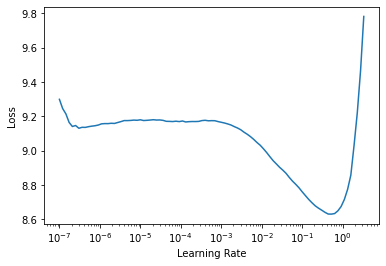

In [ ]:
#Use the lr_find method to select the best learning rate for the one-cycle_fit method.
best_lr = learn.lr_find()

In [ ]:
#Create a function to carry out the language model training schedule.
def train_language_model(model):
  # Choose some of the learning rates in reference to the graph above

  # train the model with 1 epoch and 0.01 learning rate
  learn.fit_one_cycle(1, 1e-2)
  
  # Freeze all other than the last two parameter group and train the model again with 1 epoch
  # using different learning rate 
  model.freeze_to(-2)
  model.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
  
  # Unfreeze one more layer (freeze other than the last three) and train again with 1 epoch
  # using different learning rate 
  model.freeze_to(-3)
  model.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

  # Unfreeze all of the layer (use the whole model)
  model.unfreeze()  
  # Train again for the last time with 5 epochs and 0.001 learning rate
  model.fit_one_cycle(5, 1e-3)  
  
  #save the language encoder into our file to be used later
  model.save_encoder(home_directory+language_directory+'/language_model-new')

In [ ]:
train_language_model(learn)

epoch,train_loss,valid_loss,accuracy,time
0,6.964817,6.601659,0.075579,02:53


epoch,train_loss,valid_loss,accuracy,time
0,6.609570,6.345124,0.090517,02:55


epoch,train_loss,valid_loss,accuracy,time
0,6.397820,6.213378,0.099171,03:10


epoch,train_loss,valid_loss,accuracy,time
0,6.240327,6.162550,0.103230,03:20
1,6.158850,6.073555,0.109742,03:19
2,6.060542,5.995812,0.116129,03:20
3,5.952500,5.954308,0.119596,03:19
4,5.895255,5.944240,0.120648,03:19


**Section 6**

Commence Word Classifier Model Development using the fastai package to build an ULMFiT.  

In [ ]:
def initalise_classifier(input_df):
  #Construct a data loader for the abstract classifier.
  d_class = TextDataLoaders.from_df(input_df, text_col='Words', label_col='Label', valid_col='test')

  #Decalre a new model, also based on a Long-Short Term Memory to predict the abstract class.
  model = text_classifier_learner(dls = d_class, arch = AWD_LSTM, drop_mult = 0.5,  metrics=accuracy)
  #Load our previously saved encoder on top of our new model, to transfer the learning to the new model.
  model = model.load_encoder(home_directory+language_directory+'/language_model-new')

  return model

In [ ]:
#Construct the new model
learn = initalise_classifier(df)

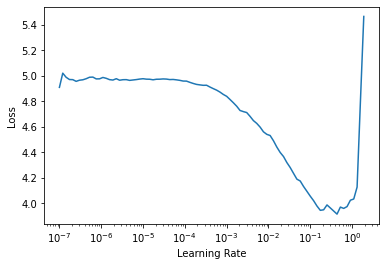

In [ ]:
#Use the lr_find method to select the best learning rate for the one-cycle_fit method.
best_lr = learn.lr_find()

In [ ]:
#Create a function to carry out the classifier training schedule.
def train_classifier_model(model):
  # Choose some of the learning rates in reference to the graph above  

  # train the model with 1 epoch and 0.01 learning rate
  model.fit_one_cycle(1, 1e-2)

  # Freeze all other than the last two parameter group and train the model again with 1 epoch
  # using different learning rate 
  model.freeze_to(-2)
  model.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

  # Unfreeze one more layer (freeze other than the last three) and train again with 1 epoch
  # using different learning rate
  model.freeze_to(-3)
  model.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

  # Unfreeze all of the layer (use the whole model)
  model.unfreeze()
  # Train again for the last time with 2 epochs
  model.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

  # return trained model
  return model

In [ ]:
#Train the classifier
learn = train_classifier_model(learn)

epoch,train_loss,valid_loss,accuracy,time
0,2.004912,1.598627,0.544046,00:48


epoch,train_loss,valid_loss,accuracy,time
0,1.719395,1.566611,0.548257,00:52


epoch,train_loss,valid_loss,accuracy,time
0,1.597906,1.513465,0.556678,01:17


epoch,train_loss,valid_loss,accuracy,time
0,1.414588,1.514310,0.556342,01:38
1,1.297370,1.506875,0.557015,01:38


In [ ]:
#Load in the test data into a dataframe.
df_test = test_df.copy()

#Construct a data loader with the test data.
d_test = learn.dls.test_dl(df_test, reorder=True, with_labels=False)

In [ ]:
#get the prediction for our test data 
#(the probability results for all of the labels and the label with the maximum probability)
preds, _, classes = learn.get_preds(dl=d_test, reorder=True, with_decoded=True)

In [ ]:
#create new column called 'label' that store the predicted label values
df_test['label']=[learn.dls.vocab[1][int(x)] for x in classes]
#create new column called 'test_id' that stores the index
df_test['test_id'] = df_test.index + 1

In [ ]:
#Export the current classifier model
learn.export(home_directory+model_directory+'/final_model.pkl')

#Export the predictions
df_test[['test_id','label']].to_csv(home_directory+output_directory+'/pred_labels.csv', index=False)